In [1]:
#py_geospatial env
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import process_ISIMIP as pISIMIP
from typing import Any, Dict, List, Tuple
import os, uuid, time, gc

#segoe ui
plt.rcParams['font.family'] = 'Segoe UI'

#### Merge ISIMIP datasets for each scenario
Since ISIMIP data is downloaded in time chunks, these chunks need to be merged for each variable and scenario to make further analysis more convenient.  
For each GCM, this code block merges all the chunks for each variable and scenario to one dataset.  

This is only done once.

In [ ]:
src_isimip = r"D:\VUB\_data\_isimip_3b"
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
variables = ['pr', 'tasmin', 'tasmax']

# Merge ISIMIP data chunks for each scenario
pISIMIP.merge_ISIMIP_datasets(src_isimip, models, scenarios, variables, verbose=False)

#### Import obs. data and compare with GCM data

In [3]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
tmax_EOBS = xr.open_dataset(f'{src}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src}/tmin.nc')
pr_EOBS = xr.open_dataset(f'{src}/pre.nc')



isimip_data = {}

#Open the datasets for each model and scenario
for model in models:
    for scenario in scenarios:
        for variable in variables:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}_merged.nc"
            if glob.glob(file_path):
                isimip_data[(model, scenario, variable)] = xr.open_dataset(file_path)


#### Extract data for comparison plots

In [4]:
tasmax_dfs= []
tasmin_dfs = []
pr_dfs = []
for model in models:
    tasmin_hist = isimip_data[(model, 'historical', 'tasmin')]
    tasmax_hist = isimip_data[(model, 'historical', 'tasmax')]
    pr_hist = isimip_data[(model, 'historical', 'pr')]

    #extract tmin and tmax over a grid
    tasmin_hist_df = (tasmin_hist['tasmin']-273.15).sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_tasmin')
    tasmax_hist_df = (tasmax_hist['tasmax']-273.15).sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_tasmax')
    tasmax_EOBS_df = (tmax_EOBS['tmax']-273.15).sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmax')
    pr_hist_df = (pr_hist['pr']*86400).sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_pr')

    #append to list
    tasmax_dfs.append(tasmax_hist_df)
    tasmin_dfs.append(tasmin_hist_df)
    pr_dfs.append(pr_hist_df)

tasmax_hist_df = pd.concat(tasmax_dfs, axis=1)
tasmin_hist_df = pd.concat(tasmin_dfs, axis=1)
pr_hist_df = pd.concat(pr_dfs, axis=1)


tasmin_EOBS_df = tmin_EOBS['tmin'].sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmin')
tasmax_EOBS_df = tmax_EOBS['tmax'].sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_tasmax')
pr_EOBS_df = pr_EOBS['pre'].sel(lat=slice(51, 48), lon=slice(5, 6)).mean(dim=['lat', 'lon']).to_dataframe(name='EOBS_pr')

#### Comparison Plots

Text(0, 0.5, 'Temperature ($^0$C)')

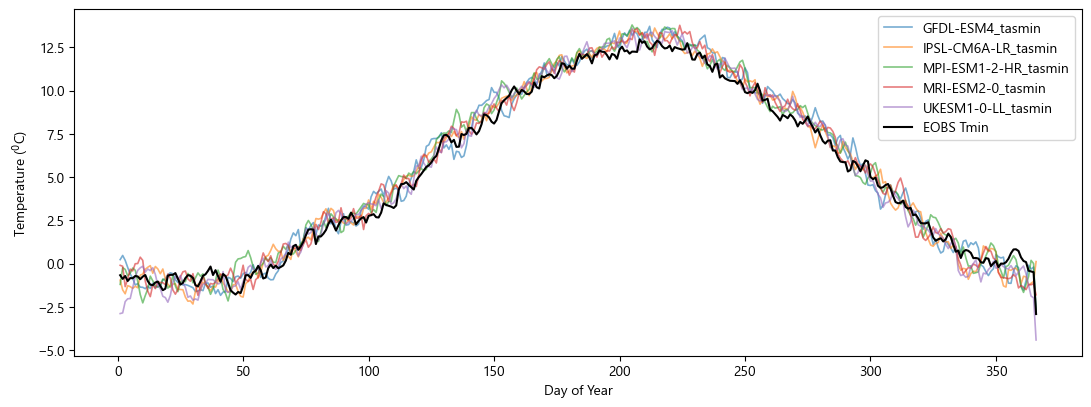

In [5]:

fig, ax = plt.subplots(figsize=(13, 4.5))


# Plotting the data
plt.plot(tasmin_hist_df.groupby(tasmin_hist_df.index.dayofyear).mean(), label=tasmin_hist_df.columns, alpha=0.6, lw=1.2)
plt.plot(tasmin_EOBS_df.groupby(tasmin_EOBS_df.index.dayofyear).mean(), color='k', label='EOBS Tmin')
#plt.plot(tmin_future_df_.groupby(tmax_future_df_.index.dayofyear).mean(), label=tmax_future_df_.columns, alpha=0.6, lw=1.2, c='orange')
plt.legend(loc='upper right', ncol=1)
plt.xlabel('Day of Year')
plt.ylabel('Temperature ($^0$C)')

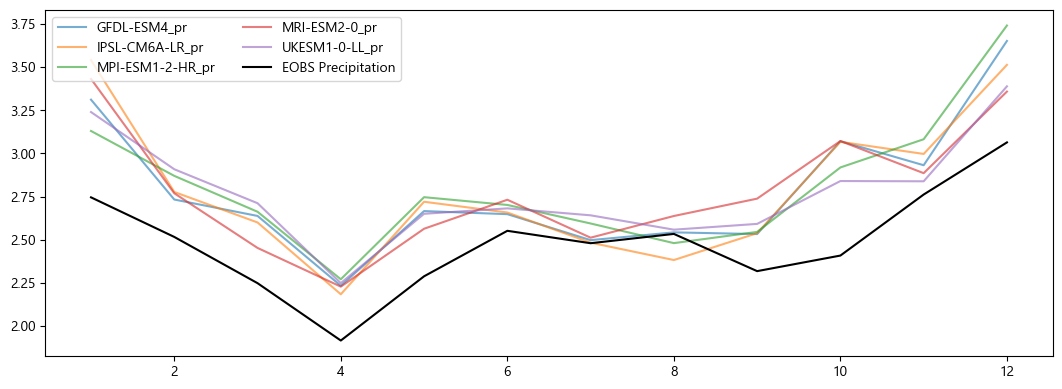

In [7]:
#Rainfall data

fig, ax = plt.subplots(figsize=(13, 4.5))

plt.plot(pr_hist_df.groupby(pr_hist_df.index.month).mean(), label=pr_hist_df.columns, alpha=0.6)
plt.plot(pr_EOBS_df.groupby(pr_EOBS_df.index.month).mean(), color='k', label='EOBS Precipitation')
plt.legend(loc='upper left', ncol=2)
  

#### Regrid ISIMIP data to match resolution of observed data

##### Prepare EOBS as reference for regridding

In [26]:
#Define the EOBS dataset and variable
dataset = pr_EOBS
var = 'pre'


obs_pre = dataset[var].sel(time=slice('1971-01-01', '2014-12-31'))
obs_pre = obs_pre.where(obs_pre.var(dim='time') > 0.0001)  # Mask out zero variance

#mask out nan columns and rows
obs_pre = obs_pre.where(obs_pre.notnull().any(dim='time')).dropna(dim='lat', how='all').dropna(dim='lon', how='all')

#### Regrid ISIMIP with XESMF

   1. Precipitation

In [ ]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "pr"              # precipitation variable key in your isimip_data
VAR_UNITS = "mm/day"         # CF-ish units string
VAR_STDNAME = "precipitation_flux"
long_name = "Regridded precipitation rate"
# -----------------------------------

isimip_regridded_pr = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_pre, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_pr = {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_pr.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")     

        isimip_hiRES_pr[name] = data_valid


In [20]:
isimip_hiRES_pr['GFDL-ESM4_historical_pr']

<xarray.Dataset> Size: 488MB
Dimensions:  (time: 16071, lat: 52, lon: 73)
Coordinates:
  * lon      (lon) float64 584B 2.25 2.312 2.375 2.438 ... 6.625 6.688 6.75
  * lat      (lat) float64 416B 51.75 51.69 51.62 51.56 ... 48.69 48.62 48.56
  * time     (time) datetime64[ns] 129kB 1971-01-01 1971-01-02 ... 2014-12-31
Data variables:
    pr       (time, lat, lon) float64 488MB nan nan nan ... 4.443 4.505 4.568
Attributes:
    regrid_method:    bilinear
    units:            mm/day
    standard_name:    precipitation_flux
    long_name:        Regridded precipitation rate
    source:           ISIMIP3b
    source_model:     GFDL-ESM4
    source_scenario:  historical

In [21]:
#Define the EOBS dataset temperature
dataset = tmax_EOBS
var = 'tmax'


obs_tmax = dataset[var].sel(time=slice('1971-01-01', '2014-12-31'))
obs_tmax = obs_tmax.where(obs_tmax.var(dim='time') > 0.0001)  # Mask out zero variance

#mask out nan columns and rows
obs_tmax = obs_tmax.where(obs_tmax.notnull().any(dim='time')).dropna(dim='lat', how='all').dropna(dim='lon', how='all')

2. Temperature

In [22]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "tasmax"              # precipitation variable key in your isimip_data
VAR_UNITS = "degree-celcius"         # CF-ish units string
VAR_STDNAME = "Maximum daily air temperature"
long_name = "Regridded maximum daily air temperature"
# -----------------------------------

isimip_regridded_tasmax = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_tmax, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_tmax= {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_tasmax.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")

        #rename tasmax, tasmin variable to tmax, tmin
        data_valid = data_valid.rename({'tasmax': 'tmax'})

        isimip_hiRES_tmax[name] = data_valid

In [23]:
#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
REGRID_METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "tasmin"              # variable key in isimip_data
VAR_UNITS = "degree-celcius"         # CF-ish units string
VAR_STDNAME = "Minimum daily air temperature"
long_name = "Regridded minimum daily air temperature"
# -----------------------------------

isimip_regridded_tasmin = pISIMIP.regrid_ISIMIP_to_obs(isimip_data, obs_tmax, models, scenarios, REGRID_METHOD,
                                             VAR_NAME, VAR_UNITS, VAR_STDNAME, long_name)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_hiRES_tmin= {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_tasmin.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")

        #rename tasmax, tasmin variable to tmax, tmin
        data_valid = data_valid.rename({'tasmin': 'tmin'})

        isimip_hiRES_tmin[name] = data_valid

#### Calculate average daily temperature

In [24]:
#calculate tasavg
# -----------------------------------

isimip_hiRES_tavg = {}
# Loop through each model and scenario to calculate tasavg

for model in models:
    for scenario in scenarios:
        tasmin = isimip_hiRES_tmin[f'{model}_{scenario}_tasmin']['tmin']
        tasmax = isimip_hiRES_tmax[f'{model}_{scenario}_tasmax']['tmax']
        tasavg = (tasmin + tasmax) / 2

        #change to xrDataset
        tasavg = tasavg.to_dataset(name='tavg')

        attributes = {
            'units': 'degree_celcius',
            'standard_name': 'Average daily air temperature',
            'long_name': f'Average daily air temperature for {model} {scenario}'
             
        }

        tasavg.attrs.update(attributes)

        isimip_hiRES_tavg[f'{model}_{scenario}_tavg'] = tasavg

#### Bias correct regridded ISIMIP data with EQM and QDM

In [27]:
#set obs to same extent as ISIMIP data

models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
future_scenarios = ['ssp370', 'ssp585']
method= 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
kind = "*"  # Use "+" for temperature or "*" for precipitation
VAR_NAME, VAR_UNITS, VAR_STDNAME= 'pr', 'mm/day', 'precipitation_flux'

# Bias correct the regridded ISIMIP data
"""QDM"""
isimip_bc_QDM = pISIMIP.bias_correct_ISIMIP(isimip_hiRES_pr, obs_pre, models,
                                     future_scenarios, method=method, kind=kind)
"""EDM"""
# isimip_bc_EQM = pISIMIP.bias_correct_ISIMIP(isimip_regridded_pr, obs, models,
#                                      future_scenarios, method=method)

'EDM'

##### Convert the bias corrected xrDataArrays to xrDataset

with varname=pre

In [28]:
#convert the bias-corrected data to xrDataset
isimip_bc_pr = {}

varname = 'pre'  # Use 'pre' for precipitation variable in the dataset
for name, data in isimip_bc_QDM.items():
    # Convert to xr.Dataset
    isimip_bc_pr[name] = data.to_dataset(name=varname)
    # Add attributes
    isimip_bc_pr[name].attrs['units'] = VAR_UNITS
    isimip_bc_pr[name].attrs['standard_name'] = VAR_STDNAME
    isimip_bc_pr[name].attrs['long_name'] = f"Bias-corrected {varname} using {method.upper()} method"

##### Sample plots

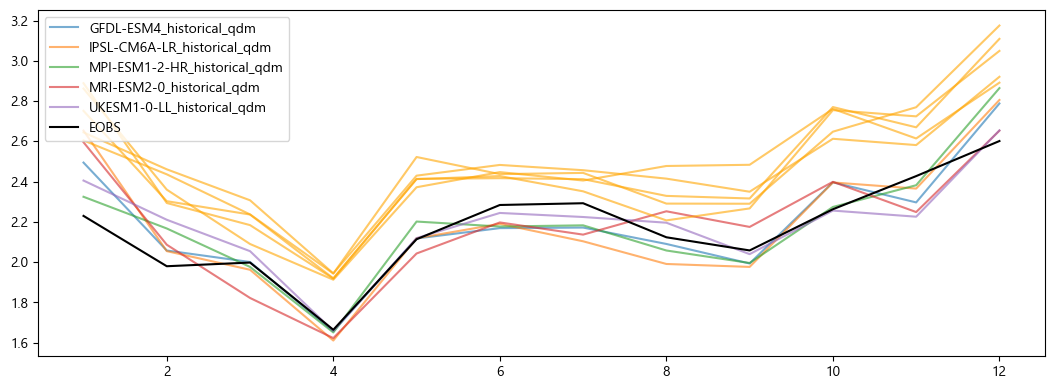

In [29]:
dict = isimip_bc_QDM
method = 'qdm'
model = 'IPSL-CM6A-LR'


minlat, maxlat = dict[f'IPSL-CM6A-LR_historical_{method}']['lat'].min(), dict[f'IPSL-CM6A-LR_historical_{method}']['lat'].max()
minlon, maxlon = dict[f'IPSL-CM6A-LR_historical_{method}']['lon'].min(), dict[f'IPSL-CM6A-LR_historical_{method}']['lon'].max()

#select the historical bc data
isimip_bc_hist = {k: dict[k] for k in dict if 'historical' in k}
#select the future bc data
isimip_bc_EQM_future = {k: dict[k] for k in dict if 'ssp370' in k}

datadf=[]
keys = list(isimip_bc_hist.keys())
for key, data in isimip_bc_hist.items():
    data_df=data.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name=key).resample('D').sum()
    datadf.append(data_df)
# Combine all dataframes into a single dataframe
dict_df = pd.concat(datadf, axis=1)
dict_df.columns = keys


#------ISIMIP historical data interpolated to EOBS grid--------
pr_dfs = []
for model in models:
    pr_hist = isimip_data[(model, 'historical', 'pr')]
    pr_hist_df = (pr_hist['pr']*86400).mean(dim=['lat', 'lon']).to_dataframe(name=model+'_pr')

    #append to list
    pr_dfs.append(pr_hist_df)

pr_hist_df = pd.concat(pr_dfs, axis=1)

#------EOBS historical data--------
obs_df = obs.mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()


#plot the bias corrected data
fig, ax = plt.subplots(figsize=(13, 4.5))
plt.plot(dict_df.groupby(dict_df.index.month).mean(), alpha=0.6, label=keys)
plt.plot(pr_hist_df.groupby(pr_hist_df.index.month).mean(), c='orange', alpha=0.6)
plt.plot(obs_df.groupby(obs_df.index.month).mean(), color='k', label='EOBS')
#plt.plot(sim_hist_df.groupby(sim_hist_df.index.month).mean(), color='r', label='model historical')
plt.legend(loc='upper left', ncol=1)

#### Export to NetCDF

In [ ]:

def export_scenarios_to_netcdf(isimip_dict, dest_isimip: str, export_scenarios: list,
                               models: list, variable: str, method: str) -> None:
    """
    Export the bias-corrected ISIMIP data to NetCDF files, safely handling file locks on Windows.
    """
    
    for model in models:
        for scenario in export_scenarios:
            if variable == 'pre':
                data = isimip_dict[f'{model}_{scenario}_{method}']
            elif variable in ['tasmin', 'tasmax', 'tavg']:
                data = isimip_dict[f'{model}_{scenario}_{variable}']
            else:
                continue

            # Load fully into memory to detach from any open NetCDF source
            data = data.load()

            # Ensure target folder exists
            out_dir = os.path.join(dest_isimip, model, scenario)
            os.makedirs(out_dir, exist_ok=True)
            out_file = os.path.join(out_dir, f"{model}_{variable}_highres.nc")

            # Temp file for atomic write
            tmp_file = os.path.join(out_dir, f".tmp_{uuid.uuid4().hex}.nc")

            # Try a few times in case file is locked
            for attempt in range(5):
                try:
                    data.to_netcdf(tmp_file, mode='w', format='NETCDF4')
                    gc.collect()
                    os.replace(tmp_file, out_file)  # Atomic replace
                    break
                except PermissionError:
                    time.sleep(0.6 * (attempt + 1))
            else:
                raise PermissionError(f"Could not write file {out_file}. "
                                      f"Ensure no other program has it open.")

In [ ]:
###     Export the bias-corrected data to NetCDF files
# -----------------------------------
export_scenarios = ['historical', 'ssp370', 'ssp585']
variable = 'tavg'
method = 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
dataset_dict = isimip_hiRES_tavg  # Use the bias-corrected precipitation data or regridded tasmin/max
dest_isimip = "D:/VUB/_data/_isimip_3b/bias_corrected"
#create if not exists
if not os.path.exists(dest_isimip):
    os.makedirs(dest_isimip)
#isimip_dict = isimip_bc_QDM

#export the regridded tasmin data
# export_scenarios_to_netcdf(dataset_dict, dest_isimip, export_scenarios, models, variable, method)


#### Seasonal changes in rainfall and temperature

In [ ]:
#changes in temperature and precipitation per scenario

for model in models:
    for scenario in future_scenarios:
        # Get the ISIMIP data for the specific model and scenario
        isimip_data_model = isimip_bc_QDM[model][scenario]
        # Get the observed data for the specific scenario
        obs_tmax_scenario = obs_tmax[scenario]
        obs_tmin_scenario = obs_tmin[scenario]
        obs_pre_scenario = obs_pre[scenario]